In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/spam-email-dataset/emails.csv


In [2]:
# First five rows
df = pd.read_csv("/kaggle/input/spam-email-dataset/emails.csv")
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
# Information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [4]:
print(f"Duplicate value in this data: {df.duplicated().sum()}")
print("We are going to delete duplicate rows")

df.drop_duplicates(inplace=True)
print(f"Successfully deleted duplicates {df.shape}")

Duplicate value in this data: 33
We are going to delete duplicate rows
Successfully deleted duplicates (5695, 2)


In [5]:
# Check how much data is imbalance?
df['spam'].value_counts()

spam
0    4327
1    1368
Name: count, dtype: int64

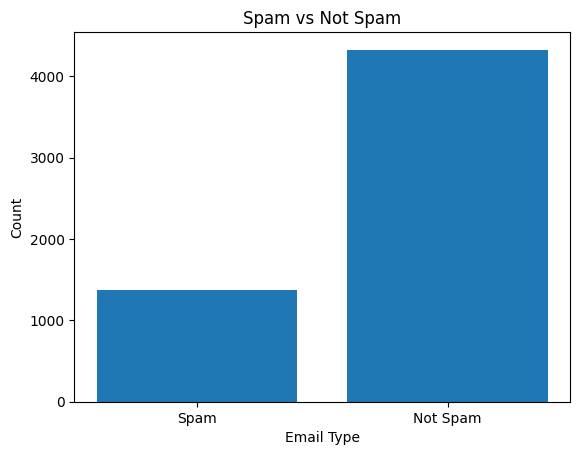

In [6]:
# Let's visualize the data

# Count the number of spam and non-spam emails
spam_count = df['spam'].value_counts()[1]
non_spam_count = df['spam'].value_counts()[0]

# Create a bar chart
plt.bar(['Spam', 'Not Spam'], [spam_count, non_spam_count])
plt.title('Spam vs Not Spam')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

The data is imbalanced, with significantly more non-spam emails than spam emails. This could potentially affect the performance of a machine learning model trained on this data, as it may be biased towards predicting non-spam emails.

### Text Processing

In [7]:
# Import Libraries
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

# Download packages
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
random_sample = df['text'].sample(3)
for text in random_sample:
  print(text,'\n')

Subject: see page 1  best regards ,  jhherbert  - gd . pdf 

Subject: re : conversation w / andersen  vince : forwarding this to you as an fyi - do you suppose you should sit in  since you ' ve already met victor ? just a thought . . .  regards ,  amy  - - - - - - - - - - - - - - - - - - - - - - forwarded by amy oberg / hou / ees on 08 / 09 / 2000 10 : 31 am  - - - - - - - - - - - - - - - - - - - - - - - - - - -  richard causey @ enron  08 / 09 / 2000 10 : 30 am  to : amy oberg / hou / ees @ ees  cc :  subject : re : conversation w / andersen  i am in the process of setting up a conference call with my contact here as  well as victor burke . prelimainary indications are they have not finalized  their objectives yet but i will discuss that further with them . i would  still strongly suggest rescheduling until everyone can attend and we can  fully discuss our involvement .  to : richard causey / corp / enron @ enron  cc :  subject : conversation w / andersen  rick :  quick follow up - an

In [9]:
# Preprocessing function
def preprocessing_text(text):
  # Lowercase the text
  text = text.lower()

  # Tokenize the text
  tokens = word_tokenize(text)

  # Remove punctuation and non-alphanumeric characters
  tokens = [word for word in tokens if word.isalnum()]

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  # Initialize steming
  stemmer = PorterStemmer()
  tokens = [stemmer.stem(word) for word in tokens]

  # Join tokens back into a processed text
  processed_text = ' '.join(tokens)

  return processed_text

In [10]:
# Assign a new column with processed text
df['processed_text'] = df['text'].apply(preprocessing_text)
df['processed_text'].sample(5)

4701    subject california power 1 19 00 execut summar...
2114    subject garp 2001 convent frank assum want tak...
2087    subject risk 2000 panel discuss steve meet 8 0...
4052    subject texa financ festiv urgent request pegg...
1492    subject dinner thur even vinc greet advis ami ...
Name: processed_text, dtype: object

### Split data `(train & test)` and Vectorize the text data

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
X_text = df['processed_text']
y_labels = df['spam']
X_train, X_test, y_train, y_test = train_test_split(X_text,
                                                    y_labels,
                                                    test_size=0.3,
                                                   random_state=42)

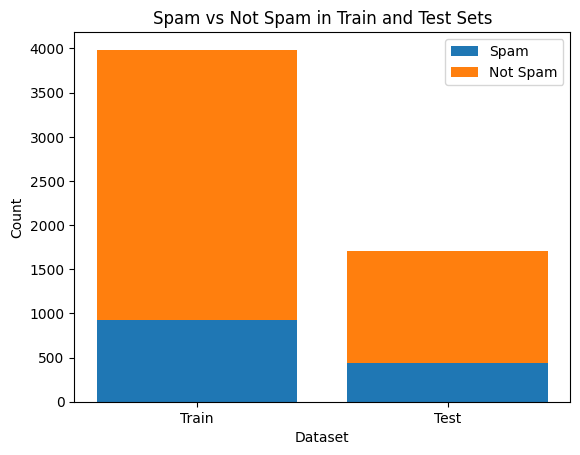

In [13]:
# Let's visualize the number of spam and non-spam emails in the train and test sets.
spam_counts = [y_train.value_counts()[1], y_test.value_counts()[1]]
non_spam_counts = [y_train.value_counts()[0], y_test.value_counts()[0]]

x_labels = ['Train', 'Test']

plt.bar(x_labels, spam_counts, label='Spam')
plt.bar(x_labels, non_spam_counts, bottom=spam_counts, label='Not Spam')
plt.title('Spam vs Not Spam in Train and Test Sets')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.legend()
plt.show()

In [14]:
# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"X_train_vec: {X_train_vec.toarray().shape}")
print(f"X_test_vec: {X_test_vec.toarray().shape}")

X_train_vec: (3986, 24812)
X_test_vec: (1709, 24812)


### Convert vectorized data and labels into PyTorch tensor

In [15]:
import torch
# Device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
# Convert data & labels into PyTorch tensor
X_train_tensor = torch.tensor(X_train_vec.toarray(),
                             dtype=torch.float32,
                             device=device)
y_train_tensor = torch.tensor(y_train.values,
                             dtype=torch.float32,
                             device=device)
X_test_tensor = torch.tensor(X_test_vec.toarray(),
                             dtype=torch.float32,
                             device=device)
y_test_tensor = torch.tensor(y_test.values,
                             dtype=torch.float32,
                             device=device)

### Create TensorDatasets and DataLoaders

In [17]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=True)

### Let's build a simple feedforward neural network model

In [18]:
from torch import nn

# Define model
class SpamFilter(nn.Module):
    def __init__(self, input_size):
        super(SpamFilter, self).__init__()
        self.layer1 = nn.Linear(in_features=input_size,
                               out_features=128)
        
        self.layer2 = nn.Linear(in_features=128,
                               out_features=64 )
        
        self.layer3 = nn.Linear(in_features=64,
                               out_features=1 )
        
    def forward(self, x):
        out = torch.relu(self.layer1(x))
        out = torch.relu(self.layer2(out))
        out = torch.sigmoid(self.layer3(out))
        return out

### Initialize model & define loss function and optimizer

In [19]:
# Initialize the model
input_size = X_train_vec.shape[1]
model0 = SpamFilter(input_size).to(device)

In [20]:
# loss function
criterion = nn.BCELoss()

# optimizer
optimizer = torch.optim.Adam(params=model0.parameters(),
                            lr=0.001)

### Let's build a training loop & evaluate our model

In [21]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model0.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model0(inputs)
        
        loss = criterion(outputs, labels.unsqueeze(1))        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
     
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}')

Epoch 1/10, Loss: 14.205428590998054
Epoch 2/10, Loss: 1.0402323715388775
Epoch 3/10, Loss: 0.44840929237398086
Epoch 4/10, Loss: 0.11797932724584825
Epoch 5/10, Loss: 0.06225612500566058
Epoch 6/10, Loss: 0.039655849021073664
Epoch 7/10, Loss: 0.025968818405090133
Epoch 8/10, Loss: 0.018862724935388542
Epoch 9/10, Loss: 0.014185117831630123
Epoch 10/10, Loss: 0.01119757549872702


In [22]:
# Evaluation
model0.eval()

correct = 0
total = 0

with torch.inference_mode():
    for inputs, labels in test_loader:
        outputs = model0(inputs)
        predicted = (outputs > 0.5).float()
        
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(dim=1)).sum().item()

accuracy = correct / total
print('Test Accuarcy: {:.2f}%'.format(100 * accuracy))


Test Accuarcy: 99.24%


### Use trained model to classify new emails

In [23]:
spam_email = """Subject: Urgent: Claim Your Prize Now!

Congratulations! You have been selected as the lucky winner of our grand prize giveaway! Claim your prize now by clicking on the link below. Don't miss out on this amazing opportunity!

Click here to claim your prize: superlottery@gmail.com

Hurry, this offer is only available for a limited time!

Best Regards,
Spammy Marketing Team
"""

non_spam_email = """Subject: Meeting Agenda for Tomorrow

Hi Team,

I hope this email finds you well. I wanted to remind everyone about the meeting scheduled for tomorrow at 10:00 AM. Below is the agenda:

1. Review of project milestones
2. Discussion on upcoming deadlines
3. Any other business

Please come prepared with any updates or questions you may have. Looking forward to a productive meeting.

Best regards,
Mr. Bannerjee
"""
def classify_email(email_text):
    # Preprocess the email
    preprocessed_email = preprocessing_text(email_text)
    
    # Vectorize the preperocessed email
    vectorized_email = vectorizer.transform([preprocessed_email])
    
    # Convert the vectorized email into PyTorch tensor
    email_tensor = torch.tensor(vectorized_email.toarray(),
                               dtype=torch.float32,
                               device=device)
    
    # Use the model for inference
    output = model0(email_tensor)
    
    # If the email is spam ot not
    if output > 0.5:
        return "spam"
    else:
        return "not spam"


In [24]:
# List of emails
email_examples = [spam_email, non_spam_email]

for i, email_text in enumerate(email_examples, start=1):
    classification = classify_email(email_text)
    print(f"Email {i} is classified as {classification}")

Email 1 is classified as spam
Email 2 is classified as not spam


### Save our classification model

In [25]:
# Saving PyTorch Model
from pathlib import Path

# Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "Spam_Classification.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# Save the model's state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/Spam_Classification.pth
